In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

/local/dgursoy/Apps/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/local/dgursoy/Apps/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Image reconstruction

In [8]:
import tomopy
import dxchange

# Set path to the micro-CT data to reconstruct.
fname = '/local/decarlo/sector1/g120f5/g120f5_'

# Select the sinogram range to reconstruct.
start = 100
end = 116

# Read the APS 1-ID raw data.
proj, flat, dark = dxchange.read_aps_1id(fname, sino=(start, end))

# Set data collection angles as equally spaced between 0-180 degrees.
theta = tomopy.angles(proj.shape[0], ang1=0.0, ang2=360.0)

# Flat-field correction of raw data.
proj = tomopy.normalize(proj, flat, dark)

# Ring removal.
proj = tomopy.remove_stripe_sf(proj)

# phase retrieval
proj = tomopy.retrieve_phase(proj, alpha=1e-3, pad=True)

# -log.
proj = tomopy.minus_log(proj)

# Reconstruct object using Gridrec algorithm.
rec = tomopy.recon(proj, theta, center=576, algorithm='gridrec')

# Mask each reconstructed slice with a circle.
rec = tomopy.circ_mask(rec, axis=0, ratio=0.85)

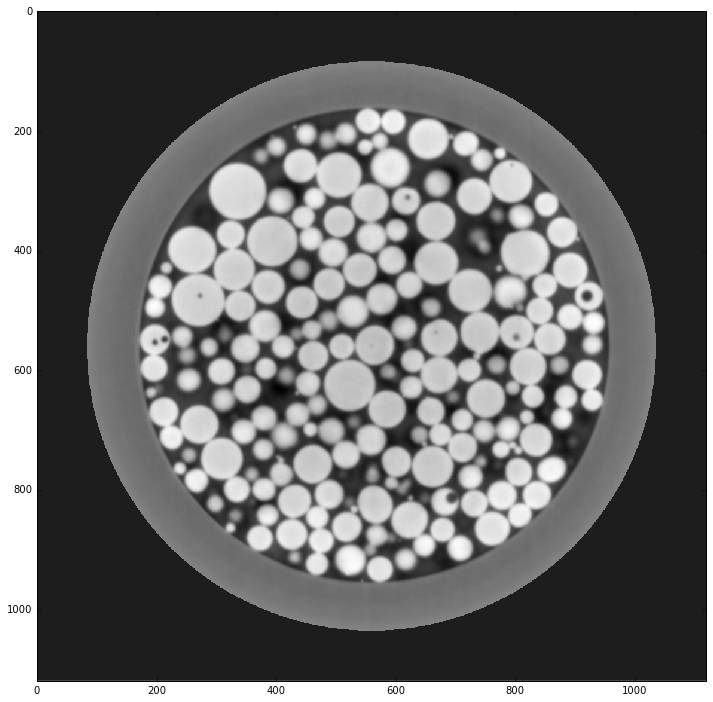

In [14]:
plt.figure(figsize=(12, 12))
plt.imshow(rec[8], cmap='gray', interpolation='none')

# Image sharpening

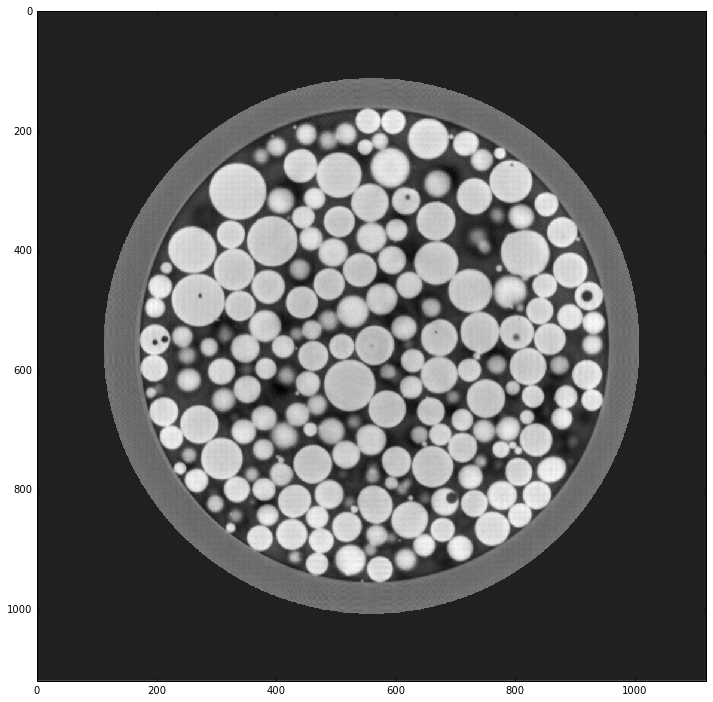

In [15]:
import cv2
import numpy as np

# Pick one slice for further processing.
img = rec[8].copy()

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img = cv2.filter2D(img, -1, kernel)
img = tomopy.circ_mask(np.expand_dims(img, 0), axis=0, ratio=0.8)[0]

plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray', interpolation='none')

# Artifact detection

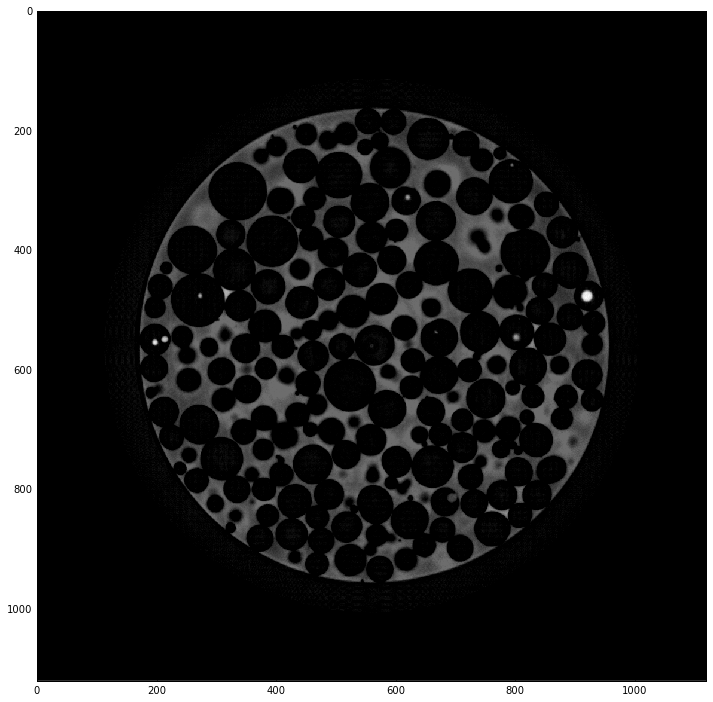

In [23]:
from skimage.morphology import reconstruction

img0 = (255 * (img - img.min()) / (img - img.min()).max()).astype('uint8')
mask = img0
seed1 = np.copy(img0)
seed2 = np.copy(img0)
seed1[1:-1, 1:-1] = img0.max()
seed2[1:-1, 1:-1] = img0.min()
eris = reconstruction(seed1, mask, method='erosion')
dila = reconstruction(seed2, mask, method='dilation')
img0 = (eris+dila-img0)
# img0 = img0 > 120

plt.figure(figsize=(12, 12))
plt.imshow(img0, cmap='gray', interpolation='none')

# Circle detection

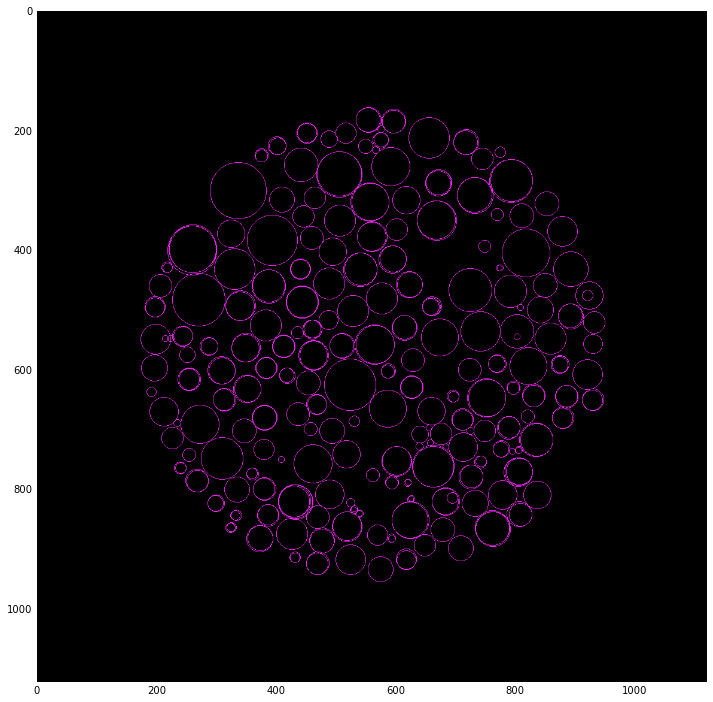

In [42]:
from skimage import color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter

img0 = (255 * (img - img.min()) / (img - img.min()).max()).astype('uint8')
edges = canny(img0, sigma=2)
hough_radii = np.arange(5, 50, 1)
hough_res = hough_circle(edges, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=300)

img1 = np.zeros(img0.shape)
img1 = color.gray2rgb(img1)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    img1[circy, circx] = (20, 220, 20)

plt.figure(figsize=(12, 12))
plt.imshow(img1)